<a href="https://colab.research.google.com/github/PasechnikDarya/RAAI-NLP-Project/blob/main/topic_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка данных

In [ ]:
import torch
import itertools
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/blogtext.csv')

In [ ]:
data.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [ ]:
data['text'][456]

"              Frustration  I'm so frustrated! At the lack of productivity. At the hunger pangs caused by waiting...waiting...waiting...  I'm meant BE at Soony and Michy's for dinner right now, yet am stuck waiting for my ride to come, who's in turn, stuck at a meeting which should have been settled eons ago. The complications of starting a new business. Sheesh...  Ah wells. Yuli is heading down now to hand me some forms for data entry. Yippee. Am finally  doing  something...           "

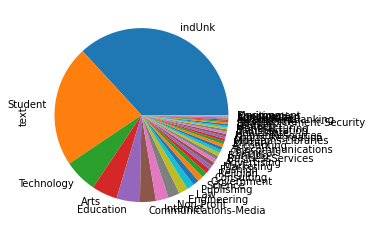

In [ ]:
data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie()

In [ ]:
NUM_CLASSES = 5

data = data[data['topic'] != 'indUnk']
classes = data.groupby('topic', as_index=False).count()[['text', 'topic']].sort_values(['text'], ascending=False)['topic'].values[:NUM_CLASSES]

data = data[data['topic'].isin(classes)]

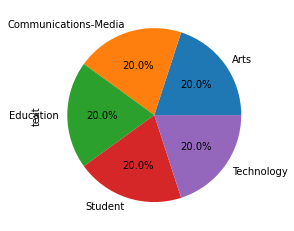

In [ ]:
data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie(autopct="%.1f%%")

In [ ]:
one_class_size = data[data['topic'] == classes[-1]].shape[0]

In [ ]:
prepr_data = pd.concat([data[data['topic'] == x][:one_class_size] for x in classes], axis=0)

In [ ]:
old_data = data
data = prepr_data.reset_index(drop=True)

In [ ]:
CUT = data.shape[0] #100000

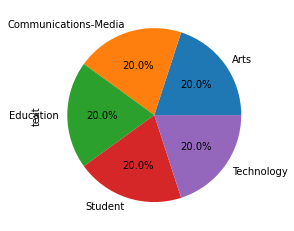

In [ ]:
data.loc[:CUT, :].groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie(autopct="%.1f%%")

In [ ]:
label2idx = {label: i for i, label in enumerate(data['topic'].unique())}
idx2label = {i: label for i, label in enumerate(data['topic'].unique())}

In [ ]:
for i in idx2label.keys():
  if label2idx[idx2label[i]] != i:
    print('aaa')

In [ ]:
from sklearn.model_selection import train_test_split

train_indexes, test_indexes = train_test_split(data.index[:CUT], test_size=0.2, stratify=data['topic'][:CUT], shuffle=True)

In [ ]:
 class Dataset:

    def __init__(self, data, labels, vocab=None):
        self.vocab = vocab
        self.data = data
        self.tokenised = None
        self.labels = [label2idx[label] for label in labels]

    def __getitem__(self, index):
        answer = {"input": self.tokenised[index]}
        if self.labels is not None:
            # answer["label"] = [0]*len(label2idx)
            # answer["label"][self.labels[index]] = 1
            answer["label"] = self.labels[index]
        return answer

    def __len__(self):
        return len(self.data)
    
    def cut_to_fixed_size(self, max_size=512):
        self.tokenised = [text[:max_size] for text in tqdm(self.tokenised)]

    def drop_too_short(self, min_size=1):
      self.labels = [label for idx, label in tqdm(enumerate(self.labels)) if len(self.tokenised[idx]) > min_size]
      self.data = [text for idx, text in tqdm(enumerate(self.data)) if len(self.tokenised[idx]) > min_size]
      self.tokenised = [text for text in tqdm(self.tokenised) if len(text) > min_size]


In [ ]:
train_dataset = Dataset(list(data['text'].values[train_indexes]), list(data['topic'].values[train_indexes]))
test_dataset = Dataset(list(data['text'].values[test_indexes]), list(data['topic'].values[test_indexes]))

In [ ]:
import nltk

nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords as nltk_stopwords

nltk_stopwords = nltk_stopwords.words("english")

def is_word(word):
    word = word.lower()
    return all(x.isalpha() or x.isdigit() or x == "-" for x in word) and any(x.isalpha() or x.isdigit() for x in word)

def process_text(text, to_lower=True, only_alpha=True, remove_stopwords=False):
    words = wordpunct_tokenize(text) if isinstance(text, str) else text
    if to_lower:
        words = [word.lower() for word in words]
    if only_alpha:
        words = [word for word in words if is_word(word)]
    if remove_stopwords:
        words = [word for word in words if word not in nltk_stopwords]
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_dataset.tokenised = [process_text(text, remove_stopwords=True) for text in tqdm(train_dataset.data)]
test_dataset.tokenised = [process_text(text, remove_stopwords=True) for text in tqdm(test_dataset.data)]

In [ ]:
class Vocabulary:

    def __init__(self, vocab=None):
        self.vocab = vocab

    def encode(self, data):
        if isinstance(data, list) and len(data) > 0 and not isinstance(data[0], str):
            return [self.encode(text) for text in data]
        # data --- это отдельный текст
        indexes = [self.vocab.get(token, self.vocab['unk']) for token in data]
        return indexes

In [ ]:
import gensim.downloader as api
glove_model = api.load("glove-twitter-50")

In [248]:
glove_word2idx = {word: idx for idx, word in enumerate(glove_model.index2word)}

glove_vocab = Vocabulary()
glove_vocab.vocab = glove_word2idx
# dataset.vocab = glove_vocab

In [249]:
train_dataset.tokenised = glove_vocab.encode(train_dataset.tokenised)
test_dataset.tokenised = glove_vocab.encode(test_dataset.tokenised)

In [250]:
train_dataset.cut_to_fixed_size(128)
test_dataset.cut_to_fixed_size(128)

In [251]:
train_dataset.drop_too_short()
test_dataset.drop_too_short()

In [252]:
len(test_dataset.labels), len(test_dataset.tokenised)

(19915, 19915)

In [253]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def pad_tensor(vec, length, dim, pad_symbol):
    pad_size = list(vec.shape)
    pad_size[dim] = length - vec.shape[dim]
    answer = torch.cat([vec, torch.ones(*pad_size, dtype=vec.dtype) * pad_symbol], axis=dim)
    return answer

def pad_tensors(tensors, dim=0, pad=0):
    # дополняет тензоры из tensors до общей максимальной длины символом pad
    if isinstance(tensors[0], (int, np.integer)):
        # массив целых чисел
        return torch.LongTensor(tensors)
    elif isinstance(tensors[0], (float, np.float)):
        # массив действительных чисел
        return torch.Tensor(tensors)
    if not isinstance(tensors[0], torch.Tensor):
        # приводим к массивам, чтобы можно было определить тип
        tensors = [np.array(tensor) for tensor in tensors]
        if np.issubdtype(tensors[0].dtype, np.integer):
            tensors = [torch.LongTensor(tensor) for tensor in tensors]
        else:
            tensors = [torch.Tensor(tensor) for tensor in tensors]
    L = max(tensor.shape[0] for tensor in tensors)
    tensors = [pad_tensor(tensor, L, dim=dim, pad_symbol=pad) for tensor in tensors]
    return torch.stack(tensors, dim=0)


class BatchDataLoader(DataLoader):

    def __init__(self, data, batch_size: int=32, pad=0, device="cpu", sort_field="input"):
        self.data = data
        self.batch_size = batch_size
        self.pad = pad
        self.device = device
        self.sort_field = sort_field

    def __iter__(self):
        self.order = np.argsort([len(elem[self.sort_field]) for elem in self.data])[::-1]
        self.idx = 0
        return self

    def __len__(self):
        return (len(self.data)-1) // self.batch_size + 1

    def __next__(self):
        if self.idx >= len(self.data):
            raise StopIteration()
        end = min(self.idx + self.batch_size, len(self.data))
        indexes = self.order[self.idx:end]
        # print(self.idx, end, indexes)
        answer = dict()
        for field in self.data[indexes[0]]:
            # записываем тензоры для всех полей
            answer[field] = pad_tensors([self.data[i][field] for i in indexes]).to(self.device)
        # записываем индексы всех объектов
        answer["indexes"] = indexes
        self.idx = end
        return answer

In [254]:
class LSTMModel(nn.Module):
    def __init__(self, num_classes, embed_size, vocab_size, hidden_size=128, mean=False):
        super().__init__()
        self.mean = mean
        self.n_hidden = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.cls = nn.Linear(hidden_size * 2, num_classes)
        # self.ac = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.embedding(x)
        lstm_outputs, states = self.lstm(x) #[:, -1, :]
        state = states[0]
        if self.mean:
            state = torch.mean(lstm_outputs, dim=1)
        else:
            # state.shape = (B, 2, H)
            state = state.permute((1, 0, 2))
            # state.shape = (B, 2*H)
            state = state.reshape(-1, 2*self.n_hidden)

        output = self.cls(state)
        # print(hidden.shape)
        # output = self.ac(hidden)
        return output

In [255]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [256]:
def freeze_embeddings(model, req_grad=False):
    embeddings = model.embedding
    for c_p in embeddings.parameters():
        c_p.requires_grad = req_grad

def measure_quality(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy: {:.2f}".format(100 * accuracy))
    precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred)
    print("precision: {:.2f}(positive), {:.2f}(negative)".format(*(100 * precision)))
    print("recall: {:.2f}(positive), {:.2f}(negative)".format(*(100 * recall)))
    print("F1-score: {:.2f}(positive), {:.2f}(negative)".format(*(100 * f_score)))
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "F1": f_score}

In [257]:
from tqdm.notebook import tqdm, trange

def training_freeze(model, criterion, optimizer, num_epochs, loaders, max_grad_norm=2, num_freeze_iter=1000):
    freeze_embeddings(model)
    for e in trange(num_epochs, leave=False):
        model.train()
        num_iter = 0
        pbar = tqdm(loaders["train"], leave=False)
        for batch in pbar:
            if num_iter > num_freeze_iter and e < 1:
                freeze_embeddings(model, True)
            optimizer.zero_grad()
            input_embeds = batch["input"].to(device)
            labels = batch["label"].to(device)
            prediction = model(input_embeds)
            # print(prediction)
            # print(labels.shape)
            loss = criterion(prediction, labels)
            if num_iter % 1000 == 0:
                print(loss)
                print(prediction.argmax(-1))
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            num_iter += 1
        valid_loss = 0
        valid_acc = 0
        num_iter = 0
        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for batch in loaders["test"]:
                input_embeds = batch["input"].to(device)
                labels = batch["label"].to(device)
                prediction = model(input_embeds)
                valid_loss += criterion(prediction, labels)
                correct += (labels == prediction.argmax(-1)).float().sum()
                num_objs += len(labels)
                num_iter += 1
        print(prediction.argmax(-1))
        print(labels)
        labels = labels.cpu().numpy()
        prediction = np.argmax(prediction.cpu().numpy(), axis=1)

        print(f"Valid Loss: {valid_loss / num_iter}, accuracy: {correct/num_objs}")
        # print('labels.shape =', labels.shape)
        # print(labels)
        # print('prediction.shape =', prediction.shape)
        # print(prediction)

        measure_quality(labels, prediction)
        print()
        print(f"Valid Loss: {valid_loss / num_iter}, accuracy: {correct/num_objs}, pred: {prediction[0]}")

In [258]:
import torch
del loaders, model
torch.cuda.empty_cache()
import gc
gc.collect()

101806

In [259]:
set(train_dataset.labels)

{0, 1, 2, 3, 4}

In [260]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMModel(len(label2idx), embed_size=glove_model.vector_size, vocab_size=len(glove_vocab.vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
max_grad_norm = 1.0

In [261]:
model.embedding.weight[0]

tensor([ 0.9448, -3.5097,  1.0408,  1.8528, -0.4308, -0.2585,  0.6139,  0.3943,
         0.5005,  1.3415, -0.2698,  0.5292, -0.5805, -1.0897, -0.1640, -0.6579,
         0.1898, -0.5950, -0.4066, -0.1922, -2.1249, -0.2286,  0.0874,  1.0773,
        -1.4580,  0.1288, -0.7493, -0.4504,  1.7817,  3.5143,  0.5718, -0.0996,
        -0.9294, -0.5824, -1.7340,  0.1940,  0.8980,  1.8139, -0.8766, -0.4256,
         1.5250, -0.9877,  0.5164, -0.3558, -0.8270, -1.0688,  0.3400, -1.6800,
         0.2559, -1.2743], device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
with torch.no_grad():
    for word, idx in glove_vocab.vocab.items():
        if word in glove_model:
            model.embedding.weight[idx] = torch.from_numpy(glove_model.get_vector(word))

In [ ]:
model.embedding.weight[0]

In [ ]:
loaders = {'train': BatchDataLoader(train_dataset, device="cuda:0", batch_size=30),
           'test': BatchDataLoader(test_dataset, device="cuda:0", batch_size=30)}

In [ ]:
training_freeze(model, criterion, optimizer, num_epochs, loaders, max_grad_norm)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, num_classes, embed_size, vocab_size, hidden_size=128, mean=False):
        super().__init__()
        self.mean = mean
        self.n_hidden = hidden_size
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.cls = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_outputs, states = self.lstm(x) #[:, -1, :]
        state = states[-1]
        if self.mean:
            state = torch.mean(lstm_outputs, dim=1)
        else:
            # state.shape = (B, 2, H)
            state = state.permute((1, 0, 2))
            # state.shape = (B, 2*H)
            state = state.reshape(-1, 2*self.n_hidden)

        output = self.cls(state)
        # print(hidden.shape)
        # output = self.ac(hidden)
        return output

    def train_on_batch(self, x, y):
        self.train()
        self.optimizer.zero_grad()
        loss = self._validate(x, y)
        loss["loss"].backward()
        self.optimizer.step()
        return loss

    def validate_on_batch(self, x, y):
        self.eval()
        with torch.no_grad():
            return self._validate(x, y)

    def _validate(self, x, y):
        if self.device is not None:
            y = y.to(self.device)
            x = x.to(self.device)
        prediction = self(x) #   self.forward(x) = self.__call__(x)
        loss = self.criterion(prediction, y)
        labels = prediction.argmax(-1)
        return {"loss": loss, "label": labels}

In [ ]:
def update_metrics(metrics, batch_output, batch_labels):
    n_batches = metrics["n_batches"]
    # Что здесь не так?
    metrics["loss"] = (metrics["loss"] * n_batches + batch_output["loss"].item()) / (n_batches + 1)
    metrics["n_batches"] += 1
    are_equal = (batch_output["label"] == batch_labels).cpu().numpy().astype("int")
    metrics["correct"] += are_equal.sum()
    metrics["total"] += are_equal.shape[0]
    metrics["accuracy"] = metrics["correct"] / max(metrics["total"], 1)

In [ ]:
def do_epoch(model, dataloader, mode="validate", epoch=1):
    metrics = {"correct": 0, "total": 0, "loss": 0.0, "n_batches": 1}

    func = model.train_on_batch if mode == "train" else model.validate_on_batch
    progress_bar = tqdm(dataloader, leave=True)
    progress_bar.set_description(f"{mode}, epoch={epoch}")

    for batch in progress_bar:
        batch_output = func(batch['input'], batch["label"])
        update_metrics(metrics, batch_output, batch["label"])
        progress_bar.set_postfix({"loss": round(metrics["loss"], 4), "acc": round(100 * metrics["accuracy"], 2)})
    return metrics

In [ ]:
train_dataloader = BatchDataLoader(train_dataset, device="cuda", batch_size=30)
test_dataloader = BatchDataLoader(test_dataset, device="cuda", batch_size=30)
NEPOCHS = 5

model = LSTMModel(len(label2idx), embed_size=glove_model.vector_size, vocab_size=len(glove_vocab.vocab)).to(device)

best_val_acc = 0.0
checkpoint = "checkpoint_best.pt"

for epoch in range(NEPOCHS):
    do_epoch(model, train_dataloader, mode="train", epoch=epoch+1)
    epoch_metrics = do_epoch(model, test_dataloader, mode="validate", epoch=epoch+1)

    if epoch_metrics["accuracy"] > best_val_acc:
        best_val_acc = epoch_metrics["accuracy"]
        print(f"Saving checkpoint after epoch {epoch+1}")
        torch.save(model.state_dict(), checkpoint)

model.load_state_dict(torch.load(checkpoint))
do_epoch(model, test_dataloader, mode="validate", epoch="evaluate")


Saving checkpoint after epoch 1


{'accuracy': 0.31128207723844714,
 'correct': 6150,
 'loss': 1.573903871666301,
 'n_batches': 660,
 'total': 19757}

In [ ]:
do_epoch(model, test_dataloader, mode="validate", epoch="evaluate")

Осталось:
1.   Разумные метрики вроде f1
2.   Сделать, чтобы училось, сейчас не учится
3.   С 0/1/2 полносвязными слоями, fastext и bert embendings



In [ ]:
torch.argmax(torch.Tensor([[1, 2], [5, 4]]), axis=1)

tensor([1, 0])